Author: Freddie Lloyd

## Part 3: Data Analytics

### Spotify

Spotify is a hugely popular digital audio streaming service that gives access to a vast array of songs, podcasts and videos. Spotify provide a well-maintained API with a wide range of endpoints to access different types of data.

This project will examine song data obtained from the Spotify web API via the Spotipy Python library. Spotipy is a wrapper for the API, allowing users to access all of the features in Python.

To obtain the data, a Spotify Developer account is needed, which can done with a free account. Through this, an app can be made, which subsequently provides a client ID and client secret.

Using the obtained client ID and secret ID to authenticate credentials, data can be queried from the Spotify API's endpoints.

In [4]:
# Import libraries

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#import time 

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression

In [5]:
# Configures matplotlib to show figures embedded in the notebookß
%matplotlib inline

In [170]:
# url = 'spotify.com'
# r = requests.get(url)

# r.status_code #200 means okay

In [6]:
# Authenticate client credentials flow to allow access to data

SPOTIPY_CLIENT_ID = '6707ce712ade4311b1970b5676fb226e'
SPOTIPY_CLIENT_SECRET = '7f4a7afd967f4c39aa88d8a55dfa4a94'

client_credentials_manager = SpotifyClientCredentials(SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Step 1: Crawl a real-world dataset

#### Data Collection

Having authenticated the credentials, the next step was to actually retrieve the data. To do this, a function was created that utilises two of the Spotify API's end points: search and audio features. The results of each are returned in JSON format, so were first reduced to the main variables of interest in a Pandas data frame. A single data frame was then created, merging the two results using the track id of each song.

###### Basic Information

The search endpoint receives a query value to search for, which can take many forms such as artist or album name, song title, or year of release. Additionally a type can be specified for further granularity, as well as a default limit of 50 songs per search. The search endpoint returns various kinds of data on the query. 


As a provisional aim of the project is to examine changes in music over time, the query was configured to return songs by the inputted year of release. 

The search query results were then reduced to just the required variables, which are mainly basic information on each song. The variables taken are defined as follows:

- Artist - The artist who released the song.
- Song - The name of the song.
- Popularity - The popularity of a song, given a value between 0-100 where 100 is the most popular.
- Release Date - The date of the first release of the album containing the song.
- Song Length - The song length in milliseconds.
- Explicit - Whether the song has explicit lyrics. False means it does not or it is unknown.
- Track ID - The ID associated with the song.


###### Audio Features

After this, the audio features from eack song were retrieved, using the track ids from the search query as an argument. Spotify provides various metrics in the audio features endpoint, derived from their own internal algorithms. Whilst it would be better to know the exact derivation of these metrics, they should still provide a reasonable basis for analysis. 

The metrics are defined by Spotify as follows:

- Acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<br>
- Danceability - Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<br>
- Energy - A measure from 0.0 to 1.0 and representing a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<br>
- Instrumentalness - Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<br>
- Key - The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
<br>
- Liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<br>
- Loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
<br>
- Mode - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
<br>
- Speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<br>
- Tempo - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
<br>
- Time Signature - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". 
<br>

- Valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).




In [23]:
def get_years_songs(years):
    """
    Inputs a year or range of years and returns a data
    frame containing comprehensive information about songs from
    that year or range of years.

    Parameters: 
        years - The year or range of years to search for

    Returns:
        songs_info - A data frame containing all variables of interest
    """  
    
    artist = []
    track_name = []
    track_id = []
    release_date = []
    track_length = []
    explicit = []
    popularity = []
    
    # Search endpoint has a 50 result limit, so loop over it to return 1000 results per search.
    
    for i in range(0, 1000, 50):
        years_songs = sp.search(q='year:' + years, type='track', limit = 50, offset = i)


        for item in years_songs['tracks']['items']:
            
            artist.append(item['artists'][0]['name'])
            track_name.append(item['name'])
            track_id.append(item['id'])
            release_date.append(item['album']['release_date'])
            track_length.append(item['duration_ms'])
            explicit.append(item['explicit'])
            popularity.append(item['popularity'])
            
                
    songs_base_info = pd.DataFrame({'decade' : years,
                                    'artist' : artist,
                                    'song' : track_name,
                                    'track id' : track_id,
                                    'release date' : release_date,
                                    'song length (ms)' : track_length,
                                    'explicit' : explicit,
                                    'popularity' : popularity})
    
    
    acousticness = []
    danceability = []
    energy = []
    instrumentalness = []
    key = []
    liveness = []
    loudness = []
    mode = []
    speechiness = []
    tempo = []
    time_signature = []
    valence = []

    
    # Retrieve audio features of each of the songs returned in the search query.
    
    track_ids = songs_base_info['track id']  

    for song_id in track_ids:

        song_audio_features = sp.audio_features(song_id) # POSSIBLY CHANGE TO PROVIDE ALL ID'S AT ONCE
        
        if song_audio_features[0] != None:
            
            # Append interesting metrics
            acousticness.append(song_audio_features[0]['acousticness'])
            danceability.append(song_audio_features[0]['danceability'])
            energy.append(song_audio_features[0]['energy'])
            instrumentalness.append(song_audio_features[0]['instrumentalness'])
            key.append(song_audio_features[0]['key'])
            liveness.append(song_audio_features[0]['liveness'])
            loudness.append(song_audio_features[0]['loudness'])
            mode.append(song_audio_features[0]['mode'])
            speechiness.append(song_audio_features[0]['speechiness'])
            tempo.append(song_audio_features[0]['tempo'])
            time_signature.append(song_audio_features[0]['time_signature'])
            valence.append(song_audio_features[0]['valence'])
            
        # In case song returned with no audio features available    
        elif song_audio_features[0] == None:
            
            acousticness.append('N/A')
            danceability.append('N/A')
            energy.append('N/A')
            instrumentalness.append('N/A')
            key.append('N/A')
            liveness.append('N/A')
            loudness.append('N/A')
            mode.append('N/A')
            speechiness.append('N/A')
            tempo.append('N/A')
            time_signature.append('N/A')
            valence.append('N/A')


    
    songs_audio_info = pd.DataFrame({'track id' : track_ids,
                                     'acousticness' : acousticness,
                                     'danceability' : danceability,
                                     'energy' : energy,
                                     'instrumentalness' : instrumentalness,
                                     'key' : key,
                                     'liveness' : liveness,
                                     'loudness' : loudness,
                                     'mode' : mode,
                                     'speechiness' : speechiness,
                                     'tempo' : tempo,
                                     'time signature' : time_signature,
                                     'valence' : valence})
    

    # Combine base info with audio features info by merging on track ID

    songs_info = pd.merge(songs_base_info, songs_audio_info)
    
    
    return songs_info


To collect data for different years, another function was written to call the get_years_songs function for different time periods. Decades were chosen as the time frame, although there is also a release date variable specifiying the exact date, so there will still be access to more granular time data if needed.

In [24]:
def concat_decades(decades):
    """
    Inputs a list of decades and calls the get_years_songs
    function for each before combining them into a single
    data frame.

    Parameters: 
        decades - The decade to retrieve song information for

    Returns:
        decades_final - A data frame containing every decades
        song information.
    """  
    
    decades_songs = []

    for decade in decades:
        
        top_50_decade_songs = get_years_songs(decade)
        
        decades_songs.append(top_50_decade_songs)
        
    decades_final = pd.concat(decades_songs)
    
    
    return decades_final

Each individual decade is brought together into the same data frame, and written to a csv file.

In [25]:
decades = ["1900-1909",
           "1910-1919",
           "1920-1929",
           "1930-1939",
           "1940-1949",
           "1950-1959",
           "1960-1969",
           "1970-1979",
           "1980-1989",
           "1990-1999",
           "2000-2009",
           "2010-2019",
           "2020-2029"]

decades_dataset = concat_decades(decades)

#decades_dataset

# Export data frame as csv

decades_dataset.to_csv("decades_dataset.csv", sep = ',')

### STEP 2: Perform data preparation & cleaning

#### Data preparation & cleaning

Need to explore the number of rows and columns, ranges of values etc.

Handle missing data, if any

Perform any additional steps (parsing dates, creating additional columns, etc)

In [8]:
# Load the dataset into a dataframe using Pandas

dataset = pd.read_csv('decades_dataset.csv')

dataset

Unnamed: 0     decade           artist                   song  \
0               0  1900-1909    Peter Gabriel           Sledgehammer   
1               1  1900-1909      Royal Bliss            I Was Drunk   
2               2  1900-1909        Roy Brown      Mighty Mighty Man   
3               3  1900-1909    Peter Gabriel           Mercy Street   
4               4  1900-1909    Peter Gabriel       Shaking The Tree   
...           ...        ...              ...                    ...   
12995         995  2020-2029          Ava Max  Christmas Without You   
12996         996  2020-2029       Lil Yachty             YAE ENERGY   
12997         997  2020-2029   Rauw Alejandro           Desesperados   
12998         998  2020-2029     Joyner Lucas     Isis (feat. Logic)   
12999         999  2020-2029  Chri$tian Gate$                   NUMB   

                     track id release date  song length (ms)  explicit  \
0      3wLZ69kr5J2sb934Kpv02c         1900            295653     False   
1      1SbSX9AWecOf7v0CFTHZ4Q         1900            243840     False   
2      5tBDBrsPypLVJ9Rbpy3MNm   1900-01-30            143230     False   
3      20tRwxVyguyMwijkNtH8oP         1900            283373     False   
4      5XZVeiIA5zPA2VLDFAjvLn         1900            384493     False   
...                       ...          ...               ...       ...   
12995  1QLZKzC2pjP4ySf4ALrNhm   2020-10-15            169245     False   
12996  6og219WwSl2pU7oXyXfRMe   2021-11-13            102116      True   
12997  6ZOcbKub95XSDESsKKuH41   2021-12-11            224996      True   
12998  4h7qcXBtaOJnmrapxoWxGf   2020-03-27            236501      True   
12999  1BPBwKueIEMnUcbbs2te7B   2021-06-04            112500      True   

       popularity  acousticness  ...  energy  instrumentalness   key  \
0              44        0.0351  ...   0.620          0.000000   8.0   
1              41        0.0030  ...   0.462          0.000000   1.0   
2              42        0.8240  ...   0.374          0.000000   0.0   
3              37        0.4730  ...   0.192          0.000005   1.0   
4              35        0.0364  ...   0.543          0.000930   1.0   
...           ...           ...  ...     ...               ...   ...   
12995          82        0.4240  ...   0.596          0.000000   1.0   
12996          72        0.0378  ...   0.617          0.000000  11.0   
12997          87        0.3560  ...   0.694          0.001250   1.0   
12998          74        0.2060  ...   0.936          0.000000   1.0   
12999          75        0.0575  ...   0.598          0.000000   8.0   

       liveness  loudness  mode  speechiness    tempo  time signature  valence  
0        0.1530    -8.146   1.0       0.0293   96.392             4.0   0.6260  
1        0.3130    -9.165   1.0       0.0304  187.510             3.0   0.2610  
2        0.5810   -15.127   0.0       0.0392  106.456             4.0   0.8200  
3        0.0805   -20.742   0.0       0.0358   92.712             4.0   0.0431  
4        0.0602   -10.884   1.0       0.0353   81.006             4.0   0.6940  
...         ...       ...   ...          ...      ...             ...      ...  
12995    0.1100    -4.680   1.0       0.0458  118.078             4.0   0.3820  
12996    0.2630    -6.200   0.0       0.3030  136.010             4.0   0.4840  
12997    0.0878    -3.350   0.0       0.0783   90.020             4.0   0.5110  
12998    0.2620    -3.931   1.0       0.1670  120.004             4.0   0.7580  
12999    0.2990    -5.694   1.0       0.2640  103.791             4.0   0.8230  

[13000 rows x 21 columns]

Initial observations from looking at the dataset:

- Index from each csv has been read as first column - this is the decade rank (out of 50) of a song, but starts at 0 rather than 1.
- Some modern songs in the '1900-1909' decade appear to have mistakenly been given release date at start of century.
- Song length in milliseconds makes little sense, would be easier to understand in minutes.
- Key, mode and time signature are nominal categorical variables - their given value does not represent anything numerically.
- As popularity is based on current playtime, many christmas songs featured, particularly in older decades.

In [9]:
# Rename the columns to reflect the desired changes
dataset.rename(
    columns={
        'Unnamed: 0' : 'decade rank',
        'song length (ms)' : 'song length (mins)'
    }, inplace=True)


In [10]:
# Change song length to be given in minutes
dataset['song length (mins)'] = (dataset['song length (mins)']/1000)/60

# Change csv index column to column
dataset['decade rank'] = dataset['decade rank'] + 1

dataset



decade rank     decade           artist                   song  \
0                1  1900-1909    Peter Gabriel           Sledgehammer   
1                2  1900-1909      Royal Bliss            I Was Drunk   
2                3  1900-1909        Roy Brown      Mighty Mighty Man   
3                4  1900-1909    Peter Gabriel           Mercy Street   
4                5  1900-1909    Peter Gabriel       Shaking The Tree   
...            ...        ...              ...                    ...   
12995          996  2020-2029          Ava Max  Christmas Without You   
12996          997  2020-2029       Lil Yachty             YAE ENERGY   
12997          998  2020-2029   Rauw Alejandro           Desesperados   
12998          999  2020-2029     Joyner Lucas     Isis (feat. Logic)   
12999         1000  2020-2029  Chri$tian Gate$                   NUMB   

                     track id release date  song length (mins)  explicit  \
0      3wLZ69kr5J2sb934Kpv02c         1900            4.927550     False   
1      1SbSX9AWecOf7v0CFTHZ4Q         1900            4.064000     False   
2      5tBDBrsPypLVJ9Rbpy3MNm   1900-01-30            2.387167     False   
3      20tRwxVyguyMwijkNtH8oP         1900            4.722883     False   
4      5XZVeiIA5zPA2VLDFAjvLn         1900            6.408217     False   
...                       ...          ...                 ...       ...   
12995  1QLZKzC2pjP4ySf4ALrNhm   2020-10-15            2.820750     False   
12996  6og219WwSl2pU7oXyXfRMe   2021-11-13            1.701933      True   
12997  6ZOcbKub95XSDESsKKuH41   2021-12-11            3.749933      True   
12998  4h7qcXBtaOJnmrapxoWxGf   2020-03-27            3.941683      True   
12999  1BPBwKueIEMnUcbbs2te7B   2021-06-04            1.875000      True   

       popularity  acousticness  ...  energy  instrumentalness   key  \
0              44        0.0351  ...   0.620          0.000000   8.0   
1              41        0.0030  ...   0.462          0.000000   1.0   
2              42        0.8240  ...   0.374          0.000000   0.0   
3              37        0.4730  ...   0.192          0.000005   1.0   
4              35        0.0364  ...   0.543          0.000930   1.0   
...           ...           ...  ...     ...               ...   ...   
12995          82        0.4240  ...   0.596          0.000000   1.0   
12996          72        0.0378  ...   0.617          0.000000  11.0   
12997          87        0.3560  ...   0.694          0.001250   1.0   
12998          74        0.2060  ...   0.936          0.000000   1.0   
12999          75        0.0575  ...   0.598          0.000000   8.0   

       liveness  loudness  mode  speechiness    tempo  time signature  valence  
0        0.1530    -8.146   1.0       0.0293   96.392             4.0   0.6260  
1        0.3130    -9.165   1.0       0.0304  187.510             3.0   0.2610  
2        0.5810   -15.127   0.0       0.0392  106.456             4.0   0.8200  
3        0.0805   -20.742   0.0       0.0358   92.712             4.0   0.0431  
4        0.0602   -10.884   1.0       0.0353   81.006             4.0   0.6940  
...         ...       ...   ...          ...      ...             ...      ...  
12995    0.1100    -4.680   1.0       0.0458  118.078             4.0   0.3820  
12996    0.2630    -6.200   0.0       0.3030  136.010             4.0   0.4840  
12997    0.0878    -3.350   0.0       0.0783   90.020             4.0   0.5110  
12998    0.2620    -3.931   1.0       0.1670  120.004             4.0   0.7580  
12999    0.2990    -5.694   1.0       0.2640  103.791             4.0   0.8230  

[13000 rows x 21 columns]

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   decade rank         13000 non-null  int64  
 1   decade              13000 non-null  object 
 2   artist              13000 non-null  object 
 3   song                13000 non-null  object 
 4   track id            13000 non-null  object 
 5   release date        13000 non-null  object 
 6   song length (mins)  13000 non-null  float64
 7   explicit            13000 non-null  bool   
 8   popularity          13000 non-null  int64  
 9   acousticness        12994 non-null  float64
 10  danceability        12994 non-null  float64
 11  energy              12994 non-null  float64
 12  instrumentalness    12994 non-null  float64
 13  key                 12994 non-null  float64
 14  liveness            12994 non-null  float64
 15  loudness            12994 non-null  float64
 16  mode

Need to change key, mode and time signature to categorical variables.

In [12]:
# Change data type of nominal categorical variables

dataset['key'] = dataset['key'].astype('category')

dataset['mode'] = dataset['mode'].astype('category')

dataset['time signature'] = dataset['time signature'].astype('category')

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   decade rank         13000 non-null  int64   
 1   decade              13000 non-null  object  
 2   artist              13000 non-null  object  
 3   song                13000 non-null  object  
 4   track id            13000 non-null  object  
 5   release date        13000 non-null  object  
 6   song length (mins)  13000 non-null  float64 
 7   explicit            13000 non-null  bool    
 8   popularity          13000 non-null  int64   
 9   acousticness        12994 non-null  float64 
 10  danceability        12994 non-null  float64 
 11  energy              12994 non-null  float64 
 12  instrumentalness    12994 non-null  float64 
 13  key                 12994 non-null  category
 14  liveness            12994 non-null  float64 
 15  loudness            12994 non-null  

In [14]:
dataset['decade'].value_counts()

1900-1909    1000
1910-1919    1000
1920-1929    1000
1930-1939    1000
1940-1949    1000
1950-1959    1000
1960-1969    1000
1970-1979    1000
1980-1989    1000
1990-1999    1000
2000-2009    1000
2010-2019    1000
2020-2029    1000
Name: decade, dtype: int64

In [15]:
dataset.describe()

decade rank  song length (mins)    popularity  acousticness  \
count  13000.000000        13000.000000  13000.000000  12994.000000   
mean     500.500000            3.502096     45.292846      0.515222   
std      288.686094            1.559297     29.593120      0.369337   
min        1.000000            0.512767      0.000000      0.000001   
25%      250.750000            2.817325     14.000000      0.129000   
50%      500.500000            3.251883     57.000000      0.551000   
75%      750.250000            3.978883     71.000000      0.891000   
max     1000.000000           55.444450    100.000000      0.996000   

       danceability        energy  instrumentalness      liveness  \
count  12994.000000  12994.000000      12994.000000  12994.000000   
mean       0.581608      0.465195          0.119883      0.190029   
std        0.169151      0.257772          0.275037      0.150620   
min        0.000000      0.000020          0.000000      0.015700   
25%        0.476000      0.249000          0.000000      0.097225   
50%        0.607000      0.450000          0.000032      0.132000   
75%        0.704000      0.674000          0.013100      0.239000   
max        0.988000      1.000000          1.000000      0.989000   

           loudness   speechiness         tempo       valence  
count  12994.000000  12994.000000  12994.000000  12994.000000  
mean     -11.274871      0.129694    117.901920      0.549498  
std        5.526415      0.224042     31.531666      0.251663  
min      -45.813000      0.000000      0.000000      0.000000  
25%      -14.139500      0.035200     93.960250      0.353250  
50%      -10.503000      0.046600    114.596000      0.563000  
75%       -7.066000      0.087300    136.835250      0.756000  
max        0.844000      0.968000    220.099000      0.991000

We now look at the 1900-1909 decade in detail to examine what is going on with release date.

In [16]:
first_decade = dataset[dataset['decade'] == '1900-1909'] 

first_decade.head(10)

decade rank     decade           artist  \
0            1  1900-1909    Peter Gabriel   
1            2  1900-1909      Royal Bliss   
2            3  1900-1909        Roy Brown   
3            4  1900-1909    Peter Gabriel   
4            5  1900-1909    Peter Gabriel   
5            6  1900-1909  Frédéric Chopin   
6            7  1900-1909        Roy Brown   
7            8  1900-1909       Bobby Lyle   
8            9  1900-1909    Los Fugitivos   
9           10  1900-1909            Aiden   

                                                song                track id  \
0                                       Sledgehammer  3wLZ69kr5J2sb934Kpv02c   
1                                        I Was Drunk  1SbSX9AWecOf7v0CFTHZ4Q   
2                                  Mighty Mighty Man  5tBDBrsPypLVJ9Rbpy3MNm   
3                                       Mercy Street  20tRwxVyguyMwijkNtH8oP   
4                                   Shaking The Tree  5XZVeiIA5zPA2VLDFAjvLn   
5  Chopin: Piano Sonata No. 2 in B-Flat Minor, Op...  4tDa5P1so01pdVc5Ywl6Or   
6                 Mighty Mighty Man (Alternate Take)  6Y35mTzWPIztc6FhLu4ZaN   
7                                     Sweetest Taboo  5yFMmeRuZNt9fJwKuQhsTU   
8                                              Linda  7tcX1UUabK2AiyQelL3TV1   
9       Cry Little Sister (Theme From The Lost Boys)  6o5sSbbPF4IRfCebK2liwj   

  release date  song length (mins)  explicit  popularity  acousticness  ...  \
0         1900            4.927550     False          44       0.03510  ...   
1         1900            4.064000     False          41       0.00300  ...   
2   1900-01-30            2.387167     False          42       0.82400  ...   
3         1900            4.722883     False          37       0.47300  ...   
4         1900            6.408217     False          35       0.03640  ...   
5         1900            9.966000     False          45       0.99300  ...   
6   1900-01-01            2.452667     False          34       0.45900  ...   
7   1900-01-01            4.951333     False          34       0.26600  ...   
8   1900-01-01            3.723333     False          32       0.16500  ...   
9   1900-01-01            5.386000      True          33       0.00246  ...   

    energy  instrumentalness  key liveness  loudness  mode speechiness  \
0  0.62000          0.000000  8.0   0.1530    -8.146   1.0      0.0293   
1  0.46200          0.000000  1.0   0.3130    -9.165   1.0      0.0304   
2  0.37400          0.000000  0.0   0.5810   -15.127   0.0      0.0392   
3  0.19200          0.000005  1.0   0.0805   -20.742   0.0      0.0358   
4  0.54300          0.000930  1.0   0.0602   -10.884   1.0      0.0353   
5  0.00189          0.919000  1.0   0.0955   -28.565   1.0      0.0487   
6  0.48400          0.000000  0.0   0.0937    -7.930   0.0      0.0382   
7  0.76600          0.591000  1.0   0.0692    -9.885   1.0      0.0463   
8  0.40900          0.000000  0.0   0.2130   -11.016   1.0      0.0471   
9  0.66400          0.000004  2.0   0.5450    -4.873   0.0      0.0420   

     tempo  time signature valence  
0   96.392             4.0  0.6260  
1  187.510             3.0  0.2610  
2  106.456             4.0  0.8200  
3   92.712             4.0  0.0431  
4   81.006             4.0  0.6940  
5   93.131             4.0  0.1530  
6  104.590             4.0  0.5440  
7   89.973             4.0  0.9500  
8   78.750             4.0  0.6070  
9  145.978             4.0  0.2160  

[10 rows x 21 columns]

In [17]:
first_decade['release date'].value_counts()

1900-01-01    173
1900          124
1900-01-29    100
1900-01-30     85
1905-06-10     61
             ... 
1909-06-19      1
1905-05-16      1
1909-07-01      1
1900-05-07      1
1905-05-30      1
Name: release date, Length: 65, dtype: int64

In [18]:
first_decade[first_decade['artist'] == 'Peter Gabriel']['release date'].value_counts()

1900    16
Name: release date, dtype: int64

Looking at the value count from the release date variable for the decade '1900-1909', we can see that only almost 300 songs from the decade have the release date of the first of january 1900, or just the year 1900.

Further examination of the artists given with this decade reveal names such as Peter Gabriel, singer of the progressive rock band Genesis in the 1970's, who has 16 songs in the data frame have the release date 1900.

Subsequently, it appears safe to assume that the majority, if not all, of the songs with this release date, or 01/01/1900, are incorrect. As this makes up almost a third of the songs in this decade, the decision is made to remove the decade from the data.

In [19]:
dataset.shape

(13000, 21)

In [20]:
# Drop the 1900-1909 decade from the dataset

dataset = dataset[dataset['decade'] != '1900-1909']

In [21]:
# Confirm 50 rows removed

dataset.shape

(12000, 21)

In [22]:
#dataset

Next, we need to account for the fact that songs can appear on different albums, which are considered independent in the Spotify search endpoint. Subsequently, we try to identify which songs are duplicated.

In [23]:
# group the entries by artist_name and track_name and check for duplicates

grouped = dataset.groupby(['artist','song'], as_index=True).size()
#grouped[grouped > 1].count()

grouped[grouped > 1]

artist                        song                                             
2Pac                          California Love - Original Version                   2
311                           Amber                                                2
AC/DC                         You Shook Me All Night Long                          2
Aaliyah                       Are You That Somebody                                2
Adele                         Easy On Me                                           2
                                                                                  ..
WILLOW                        t r a n s p a r e n t s o u l feat. Travis Barker    2
Warrant                       Cherry Pie                                           2
Wheatus                       Teenage Dirtbag                                      2
Woody Herman & His Orchestra  Let It Snow! Let It Snow! Let It Snow!               2
blackbear                     idfc                                    

There are 493 duplicate rows in the data, which feature exactly the same artist and song combination. We subset the data frame to Adele songs to examine the duplicates further.

In [24]:
adele = dataset[dataset['artist'] == 'Adele']

adele[adele['song'] == 'Easy On Me']

decade rank     decade artist        song                track id  \
12005            6  2020-2029  Adele  Easy On Me  0gplL1WMoJ6iYaPgMCL0gX   
12070           71  2020-2029  Adele  Easy On Me  46IZ0fSY2mpAiktS3KOqds   

      release date  song length (mins)  explicit  popularity  acousticness  \
12005   2021-10-14              3.7449     False          98         0.578   
12070   2021-11-19              3.7449     False          92         0.578   

       ...  energy  instrumentalness  key liveness  loudness  mode  \
12005  ...   0.366               0.0  5.0    0.133    -7.519   1.0   
12070  ...   0.366               0.0  5.0    0.133    -7.519   1.0   

      speechiness    tempo  time signature valence  
12005      0.0282  141.981             4.0    0.13  
12070      0.0282  141.981             4.0    0.13  

[2 rows x 21 columns]

We now see that duplicate songs are identical in all aspects other than release date and popularity. As this is unlikely to affect analysis, it is left for now.

In [25]:
#drop_duplicates

In [26]:
# Check for any row with at least one missing value

dataset[dataset.isnull().any(axis=1)]

decade rank     decade                             artist  \
1232          233  1910-1919  Happy Birthday All Names & Genres   
1465          466  1910-1919  Happy Birthday All Names & Genres   
1536          537  1910-1919                     Jerzy Żuławski   
2853          854  1920-1929                        Ruth Etting   

                                                 song                track id  \
1232                Happy Birthday To Bob - Classical  57FhmUFCw3Onjj5QqCXRez   
1465               Happy Birthday To Mark - Classical  4uKCp1UriqqFKespsU1RlM   
1536  Chapter 21.4 - Trylogia księżycowa 2: Zwycięzca  0MqTTtsWO9hOIArg8G9knf   
2853              What Do We Do on a Dew-Dew-Dewy Day  2UWl0RM3ZLPI2RLsWAHsJG   

     release date  song length (mins)  explicit  popularity  acousticness  \
1232         1912            0.527817     False           0           NaN   
1465         1912            0.527817     False           0           NaN   
1536         1910            3.113333     False           0           NaN   
2853   1926-11-26            2.798883     False           4           NaN   

      ...  energy  instrumentalness  key liveness  loudness  mode speechiness  \
1232  ...     NaN               NaN  NaN      NaN       NaN   NaN         NaN   
1465  ...     NaN               NaN  NaN      NaN       NaN   NaN         NaN   
1536  ...     NaN               NaN  NaN      NaN       NaN   NaN         NaN   
2853  ...     NaN               NaN  NaN      NaN       NaN   NaN         NaN   

      tempo  time signature valence  
1232    NaN             NaN     NaN  
1465    NaN             NaN     NaN  
1536    NaN             NaN     NaN  
2853    NaN             NaN     NaN  

[4 rows x 21 columns]

In [27]:
dataset.shape

(12000, 21)

In [28]:
dataset.dropna(axis=0).shape

(11996, 21)

In [29]:
# Drop any rows with NaN values

dataset = dataset.dropna(axis = 0)

Check that there or there no remaining nulls in any column

In [30]:
dataset.isnull().sum()

decade rank           0
decade                0
artist                0
song                  0
track id              0
release date          0
song length (mins)    0
explicit              0
popularity            0
acousticness          0
danceability          0
energy                0
instrumentalness      0
key                   0
liveness              0
loudness              0
mode                  0
speechiness           0
tempo                 0
time signature        0
valence               0
dtype: int64

Findings: 

- The dataset has 21 columns and 11996 rows, with 500 rows from each of 12 decades after the removal of 1900-1909.
- There was four song in the data which did not have any audio features, so were removed.
- Provisionally, no additional columns are needed.
- Key, mode and time signature are nominal categorical data so have been encoded as numbers to represent the categories.
- All other audio features are continuous variables.
- Acousticness, danceabiity, energy, instrumentalness, liveness, speechiness and valence are calculated continuous variables, ranging from 0-1.
- Loudness (db) and tempo (bpm) are measured continuous variables.


### Step 3: Perform exploratory analysis and ask questions

#### Exploratory analysis

TASK - Explore your data, examples are as follows:
- Compute the mean, sum, range and other interesting statistics for numeric columns.
- Explore distributions of numeric columns using histograms etc.
- Explore the relationship between columns using scatter plots, bar charts, etc.

Before asking any questions of the data, it is first important to explore the distributions of the variables through visualisation.

**Categorical variables EDA**

We first look at the categorial variables, which are best visualised with pie charts with a low number of variables, and bar charts otherwise.

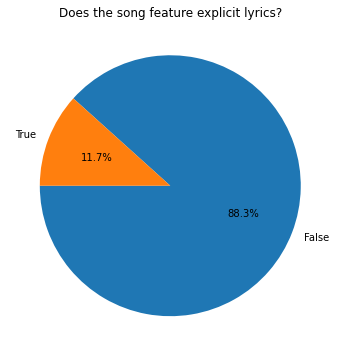

In [31]:
explicit_counts = dataset['explicit'].value_counts()

plt.figure(figsize=(12,6))
plt.title("Does the song feature explicit lyrics?")
plt.pie(explicit_counts, labels=explicit_counts.index, autopct='%1.1f%%', startangle=180);

Just under 12% of songs feature explicit lyrics, would be interesting to see if this has increased in recent times.

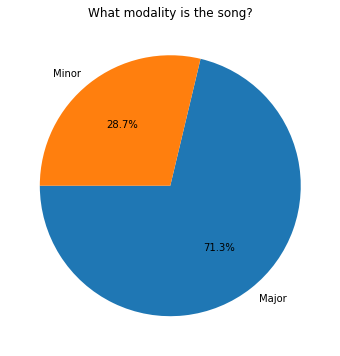

In [32]:
#The modality (major or minor) of a track, the type of scale from which its melodic content is derived. 
#Major is represented by 1 and minor is 0.
mode_counts = dataset['mode'].value_counts()

plt.figure(figsize=(12,6))
plt.title("What modality is the song?")
#plt.pie(mode_counts, labels=mode_counts.index, autopct='%1.1f%%', startangle=180);
plt.pie(mode_counts, labels=('Major', 'Minor'), autopct='%1.1f%%', startangle=180);

The ratio of major to minor songs is essentially 70:30.

In [33]:
# 0	C (also B♯, Ddouble flat)	do
# 1	C♯, D♭ (also Bdouble sharp)	
# 2	D (also Cdouble sharp, Edouble flat)	re
# 3	D♯, E♭ (also Fdouble flat)	
# 4	E (also Ddouble sharp, F♭)	mi
# 5	F (also E♯, Gdouble flat)	fa
# 6	F♯, G♭ (also Edouble sharp)	
# 7	G (also Fdouble sharp, Adouble flat)	sol
# 8	G♯, A♭	
# 9	A (also Gdouble sharp, Bdouble flat)	la
# 10, t or A	A♯, B♭ (also Cdouble flat)	
# 11, e or B	B (also Adouble sharp, C♭)


key_names = {0 : "C",
             1 : "C#/D♭",
             2 : "D",
             3 : "D#/E♭",
             4 : "E",
             5 : "F",
             6 : "F#/G♭",
             7 : "G",
             8 : "G#/A♭",
             9 : "A",
             10 : "A#/B♭",
             11 : "B"}

key_names



{0: 'C',
 1: 'C#/D♭',
 2: 'D',
 3: 'D#/E♭',
 4: 'E',
 5: 'F',
 6: 'F#/G♭',
 7: 'G',
 8: 'G#/A♭',
 9: 'A',
 10: 'A#/B♭',
 11: 'B'}

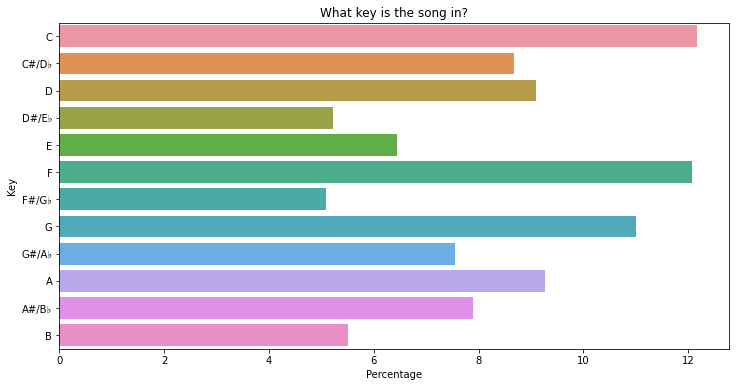

In [34]:
#0 = C, 1 = C#/D, 2=D, etc


key_counts_pct = (dataset['key'].value_counts()/dataset['key'].count())*100
#plt.pie(key_counts, labels=key_counts.index, autopct='%1.1f%%', startangle=180);

# sns.countplot(y=dataset['key'])
# #plt.figure(figsize=(12,6))
# plt.title("What key is the song in?")
# #plt.xticks(rotation=75);
# #plt.title(schema['EdLevel'])
# plt.ylabel("key");


plt.figure(figsize=(12,6))
ax = sns.barplot(x=key_counts_pct, y=key_counts_pct.index)
plt.title("What key is the song in?")
plt.ylabel("Key")
plt.xlabel('Percentage')
ax.set_yticklabels(key_names.values());

The distribution of keys is pretty even, but the most commonly used are C and F and G at over 10% each.

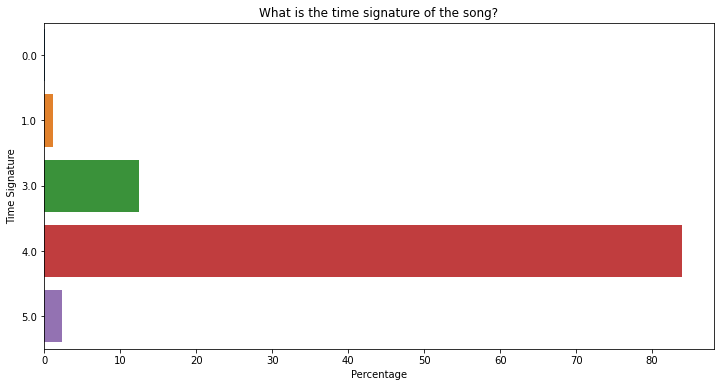

In [35]:
#how much beats in each bar (or measure)

signature_counts_pct = (dataset['time signature'].value_counts()/dataset['time signature'].count())*100

# plt.pie(signature_counts, labels=signature_counts.index, autopct='%1.1f%%', startangle=180);


plt.figure(figsize=(12,6))
sns.barplot(x=signature_counts_pct, y=signature_counts_pct.index)
plt.title("What is the time signature of the song?")
plt.ylabel("Time Signature")
plt.xlabel('Percentage');

The time signature of 4 is by far the most common, at over 80%.

**Numeric variables EDA**

Now need to explore the distributions of the numeric variables. To do this we firstly look at the describe() function giving different statistics for each variable, before plotting the histograms of each.

In [36]:
#dataset.describe(include = 'all')

dataset.describe()

decade rank  song length (mins)    popularity  acousticness  \
count  11996.000000        11996.000000  11996.000000  11996.000000   
mean     500.492664            3.478532     48.453568      0.506913   
std      288.706413            1.465857     28.518494      0.370892   
min        1.000000            0.512767      0.000000      0.000001   
25%      250.750000            2.810667     18.000000      0.117000   
50%      500.500000            3.246333     60.000000      0.533500   
75%      750.250000            3.970046     72.000000      0.887000   
max     1000.000000           42.088217    100.000000      0.996000   

       danceability        energy  instrumentalness      liveness  \
count  11996.000000  11996.000000      11996.000000  11996.000000   
mean       0.584877      0.470313          0.108708      0.187859   
std        0.166382      0.254957          0.261236      0.146799   
min        0.000000      0.000020          0.000000      0.015700   
25%        0.480000      0.257000          0.000000      0.097000   
50%        0.608000      0.458000          0.000028      0.132000   
75%        0.705000      0.678000          0.009098      0.237000   
max        0.988000      0.999000          1.000000      0.982000   

           loudness   speechiness         tempo       valence  
count  11996.000000  11996.000000  11996.000000  11996.000000  
mean     -10.957621      0.124521    118.039985      0.551099  
std        5.260095      0.214895     31.435202      0.247111  
min      -40.449000      0.000000      0.000000      0.000000  
25%      -13.757250      0.034900     94.048000      0.357000  
50%      -10.323000      0.046300    114.701500      0.564000  
75%       -6.919000      0.085600    136.991750      0.753000  
max        0.844000      0.968000    220.099000      0.991000

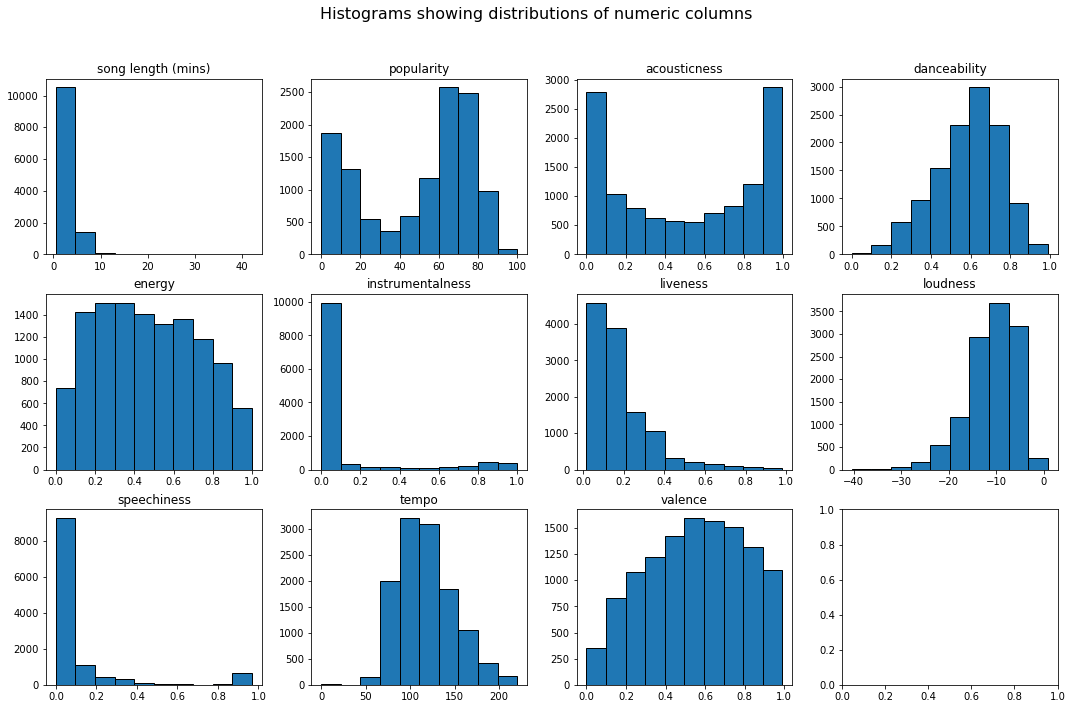

In [37]:
# titles = ['song length (mins)','popularity','acousticness','danceability', 'energy',
#          'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'] 

fig, ax = plt.subplots(3, 4, figsize = (15,10))
ax[0, 0].hist(dataset['song length (mins)'], edgecolor = 'black'), ax[0, 0].title.set_text('song length (mins)')
ax[0, 1].hist(dataset['popularity'], edgecolor = 'black'), ax[0, 1].title.set_text('popularity')
ax[0, 2].hist(dataset['acousticness'], edgecolor = 'black'), ax[0, 2].title.set_text('acousticness')
ax[0, 3].hist(dataset['danceability'], edgecolor = 'black'), ax[0, 3].title.set_text('danceability')
ax[1, 0].hist(dataset['energy'], edgecolor = 'black'), ax[1, 0].title.set_text('energy')
ax[1, 1].hist(dataset['instrumentalness'], edgecolor = 'black'), ax[1, 1].title.set_text('instrumentalness')
ax[1, 2].hist(dataset['liveness'], edgecolor = 'black'), ax[1, 2].title.set_text('liveness')
ax[1, 3].hist(dataset['loudness'], edgecolor = 'black'), ax[1, 3].title.set_text('loudness')
ax[2, 0].hist(dataset['speechiness'], edgecolor = 'black'), ax[2, 0].title.set_text('speechiness')
ax[2, 1].hist(dataset['tempo'], edgecolor = 'black'), ax[2, 1].title.set_text('tempo')
ax[2, 2].hist(dataset['valence'], edgecolor = 'black'), ax[2, 2].title.set_text('valence')
ax[2, 3]

fig.tight_layout()

plt.suptitle("Histograms showing distributions of numeric columns", size = 16)

fig.subplots_adjust(top=0.88)

#plt.show()

Observations:
- There are some very long songs of over 10 minutes, need further exploration to check if these are errors.
- Popularity score most commonly between 60-80.
- Acousticness is often very high or very low.
- Instrumentalness and speechiness are mostly very low (less than 0.1)
- There is some very loud songs of up to 40 decibels, could be an outlier, needs further exploration.
- Valence is pretty equally distributed, slightly more positive than negative

There will not be any outliers in metrics that have defined ranges, such as decade rank (1-1000), popularity (0-100), or any of the metrics which lie between 0 and 1. We therefore look at the continuous variables.

Text(0, 0.5, 'Value')

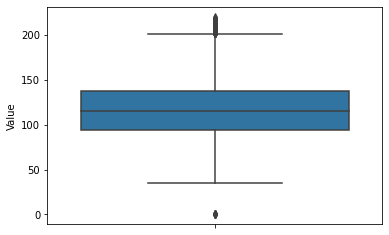

In [118]:
sns.boxplot(data = dataset, y = 'tempo')
plt.ylabel("Value")


Text(0, 0.5, 'Value')

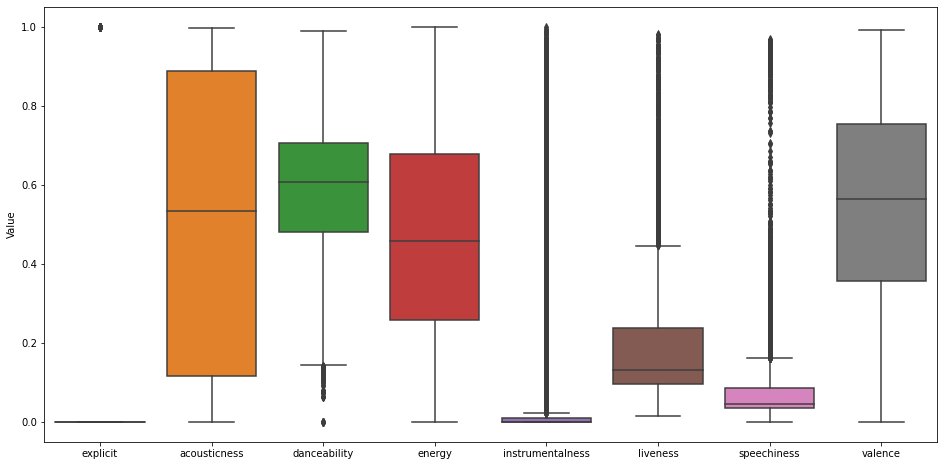

In [103]:
# _, bp = pd.DataFrame.boxplot(dataset, return_type = 'both', figsize = (15, 10)) 
plt.figure(figsize=(16,8))
# plot all columns except decade rank and popularity which will definitely not have any outliers and skew
# skew the value axis, as well as tempo
sns.boxplot(data = dataset.drop(columns = ['decade rank', 'popularity','tempo', 'song length (mins)', 'loudness']))
plt.ylabel("Value")


#plt.figure(figsize=(10,5))
# ax = sns.boxplot(data = dataset, x = 'key',y = 'popularity')
# plt.title("Popularity by musical key")
# plt.ylabel("Popularity")
# plt.xlabel('Key')
# ax.set_xticklabels(key_names.values());

This appears to support the observation from the histograms, with most significant outliers in song length, loudness and tempo. Lets examine each boxplot in greater detail.

In [39]:
#outliers = [flier.get_ydata() for flier in bp["fliers"]] #fliers = points outside whiskers

#outliers

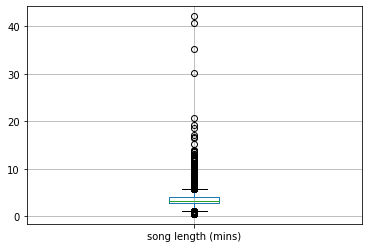

In [40]:
bp = dataset.boxplot(column='song length (mins)')

Can see in the boxplot for song length that there are a number of longer songs towards ten minutes, but one extremely long song at over 20 minutes. To check this we look at songs over ten minutes in the data frame.

In [41]:
dataset[dataset['song length (mins)'] > 10] 

decade rank     decade                    artist  \
1004             5  1910-1919      Ludwig van Beethoven   
1008             9  1910-1919      Ludwig van Beethoven   
1074            75  1910-1919       Sergei Rachmaninoff   
1110           111  1910-1919       Sergei Rachmaninoff   
1121           122  1910-1919             Bach - Busoni   
1126           127  1910-1919      Ludwig van Beethoven   
1128           129  1910-1919      Ludwig van Beethoven   
1322           323  1910-1919      Mallanaga Vatsyayana   
1515           516  1910-1919       Sergei Rachmaninoff   
1644           645  1910-1919  Bhai Sukhvinder Singh Ji   
2416           417  1920-1929       Sergei Rachmaninoff   
2690           691  1920-1929           Frédéric Chopin   
2928           929  1920-1929           Frédéric Chopin   
3402           403  1930-1939             Benny Goodman   
3464           465  1930-1939               Franz Liszt   
3531           532  1930-1939               Franz Liszt   
3552           553  1930-1939               Umm Kulthum   
3561           562  1930-1939               Franz Liszt   
3587           588  1930-1939               Umm Kulthum   
3663           664  1930-1939               Franz Liszt   
3670           671  1930-1939               Franz Liszt   
3696           697  1930-1939             Benny Goodman   
3831           832  1930-1939             Samuel Barber   
4427           428  1940-1949            Charlie Parker   
4587           588  1940-1949      Ludwig van Beethoven   
4597           598  1940-1949              Layla Mourad   
4715           716  1940-1949             Dexter Gordon   
4834           835  1940-1949            Charlie Parker   
4861           862  1940-1949      Mohammed Abdel Wahab   
4905           906  1940-1949            Duke Ellington   
4906           907  1940-1949      Ludwig van Beethoven   
4953           954  1940-1949            Darius Milhaud   
4983           984  1940-1949             Maurice Ravel   
4989           990  1940-1949            Charlie Parker   
4996           997  1940-1949               Umm Kulthum   
5219           220  1950-1959             John Coltrane   
5286           287  1950-1959       Cannonball Adderley   
5295           296  1950-1959           George Gershwin   
5298           299  1950-1959               Miles Davis   
5409           410  1950-1959               Miles Davis   
5426           427  1950-1959               Miles Davis   
5844           845  1950-1959               Miles Davis   
5864           865  1950-1959     Sonny Rollins Quartet   
5891           892  1950-1959             John Coltrane   
5909           910  1950-1959            Charles Mingus   
6595           596  1960-1969                 The Doors   
6647           648  1960-1969               Nina Simone   
6820           821  1960-1969             John Coltrane   
6840           841  1960-1969              King Crimson   
6872           873  1960-1969                 The Doors   
6890           891  1960-1969              Arlo Guthrie   
7316           317  1970-1979                Pink Floyd   
7842           843  1970-1979                Pink Floyd   
7845           846  1970-1979              Héctor Lavoe   
7938           939  1970-1979                Pink Floyd   
12004            5  2020-2029              Taylor Swift   

                                                    song  \
1004   Violin Sonata in A Major No. 9, Op. 47 "Kreutz...   
1008   Violin Concerto in D Major, Op. 61: I. Allegro...   
1074   Concerto for Piano and Orchestra No. 2 in C Mi...   
1110   Concerto for Piano and Orchestra No. 2 in C Mi...   
1121                       Chaconne in D Minor, BWV 1004   
1126   Piano Trio in B-Flat Major, Op. 97: I. Allegro...   
1128   Piano Trio in B-Flat Major, Op. 97: III. Andan...   
1322               Part 7 Chapter 2 & Concluding Remarks   
1515   Concerto for Piano and Orchestra No. 2 in C Mi...   
1644                                Sewak K

Can now see that the majority of songs over ten minutes are from the early 20th century, with several from the very famous classical composer Beethoven. Longer songs are not uncommon in classical music so we are happy to these are not mistakes and keep them in the analysis.

This does, however, bring up a separate observation which is that Beethoven died in the early 19th century, and so the release must have been posthumously released, as opposed to being a mistake in the data.

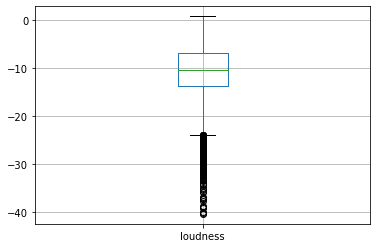

In [42]:
bp = dataset.boxplot(column='loudness')
# Sometimes you have to force display of outliers:
#bp = plt.boxplot(dataset.loudness, 0, 'ro') # red circle

The boxplot for loudness confirms that there are a number of outliers over 25 decibels. To examine this in detail we subset the database to those over 35 decibels.


In [43]:
dataset[dataset['loudness'] < -35]

decade rank     decade                artist  \
2538           539  1920-1929       Frédéric Chopin   
4011            12  1940-1949            Erik Satie   
4033            34  1940-1949            Erik Satie   
4056            57  1940-1949            Erik Satie   
4095            96  1940-1949            Erik Satie   
4231           232  1940-1949            Erik Satie   
4529           530  1940-1949            Erik Satie   
4799           800  1940-1949            Erik Satie   
4944           945  1940-1949            Erik Satie   
5870           871  1950-1959           Miles Davis   
5872           873  1950-1959           Miles Davis   
5977           978  1950-1959           Miles Davis   
6801           802  1960-1969       Robert Schumann   
9581           582  1990-1999          Dave Brubeck   
10978          979  2000-2009  Ludwig van Beethoven   
11426          427  2010-2019              Granular   

                                                    song  \
2538                Prelude in in B Minor, Op. 28, No. 6   
4011                                    Gymnopédie No. 1   
4033                                    Gymnopédie No. 3   
4056                                    Gymnopédie No. 2   
4095                                 Première Gymnopédie   
4231                  Gymnopédies: No. 3 - Lent et grave   
4529       Descriptions Automatiques: I. Sur un vaisseau   
4799   Les trois valses distingúees du precieux dégoû...   
4944                  Avant-dernières penseés: I. Idylle   
5870                     Blue in Green - Studio Sequence   
5872                         So What - Studio Sequence 1   
5977               Flamenco Sketches - Studio Sequence 1   
6801   Kinderszenen, Op. 15: No. 1, Von fremden Lände...   
9581                                      To Us Is Given   
10978  Sonata No. 14 "Moonlight" in C-Sharp Minor", O...   
11426                               White Noise - 145 hz   

                     track id release date  song length (mins)  explicit  \
2538   0UXtIindEK8abNG0ys4wnN         1928            2.119333     False   
4011   5NGtFXVpXSvwunEIGeviY3         1949            3.431100     False   
4033   0hZBK2IS2uKdWVwEWXX1vB         1949            2.923767     False   
4056   5SBERonheeqbIhNqPTctU6         1949            3.248217     False   
4095   7gzsp9dv8bKRq8gnK6NzmS         1949            3.615100     False   
4231   1nejJB7nBtpg9Ex7o08rWJ         1949            2.677333     False   
4529   0faxohcPpK2ZqQsdyGzn4x         1949            1.834000     False   
4799   4ZhCxPTM6bDFKgPOn8ff8X         1949            1.082000     False   
4944   146RU5YiaxFjgR8Byj8syE         1949            1.119100     False   
5870   4S0JzmCCQjaRjbPfIF6JV1   1959-08-17            1.948433     False   
5872   7aYP6U6rAhIzNx1DxDnBxv   1959-08-17            1.901767     False   
5977   745roqGwMrDnjNO1S3Q5ex   1959-08-17            0.705333     False   
6801   4vi9pBR7yJhBzGaNu0k1gj         1962            1.556433     False   
9581   7n76J43bOv8dO4MXCbv4Zt   1996-01-01            3.540000     False   
10978  3DNRdudZ2SstnDCVKFdXxG   2007-09-25            5.257100     False   
11426  6H4B9gJD6eQlNoEh8q85pP   2017-10-13            2.258050     False   

       popularity  acousticness  ...   energy  instrumentalness  key liveness  \
2538            6         0.991  ...  0.00500          0.809000  7.0   0.1200   
4011           71         0.994  ...  0.01280          0.937000  7.0   0.0941   
4033           57         0.991  ...  0.00766          0.873000  9.0   0.0732   
4056           50         0.992  ...  0.00243          0.963000  2.0   0.0804   
4095           43         0.995  ...  0.00808          0.922000  7.0   0.0762   
4231           30         0.996  ...  0.00348          0.957000  9.0   0.0924   
4529           20         0.993  ...  0.00722          0.937000  8.0   0.0820   
4799           16         0.996  ...  0.01590          0.957000  0.0   0.0968   
4944           13         0.

This subset again appears to show old classical songs, which could reasonably be expected to be loud so there is no reason to remove them.

**Variables Relationships EDA**

We now check for any obvious relationships within the data. A first step to do this is to create a seaborn pair grid, giving scatter plots of the relationships between all numeric variables.

In [44]:
#dataset[['artist', 'song']]

#df.drop(df.columns[[1, 2]], axis=1, inplace=True)

#dataset(axis = 1)

cols = [col for col in dataset.columns if col not in ['decade rank', 'explicit']]
pairplot_df = dataset[cols]

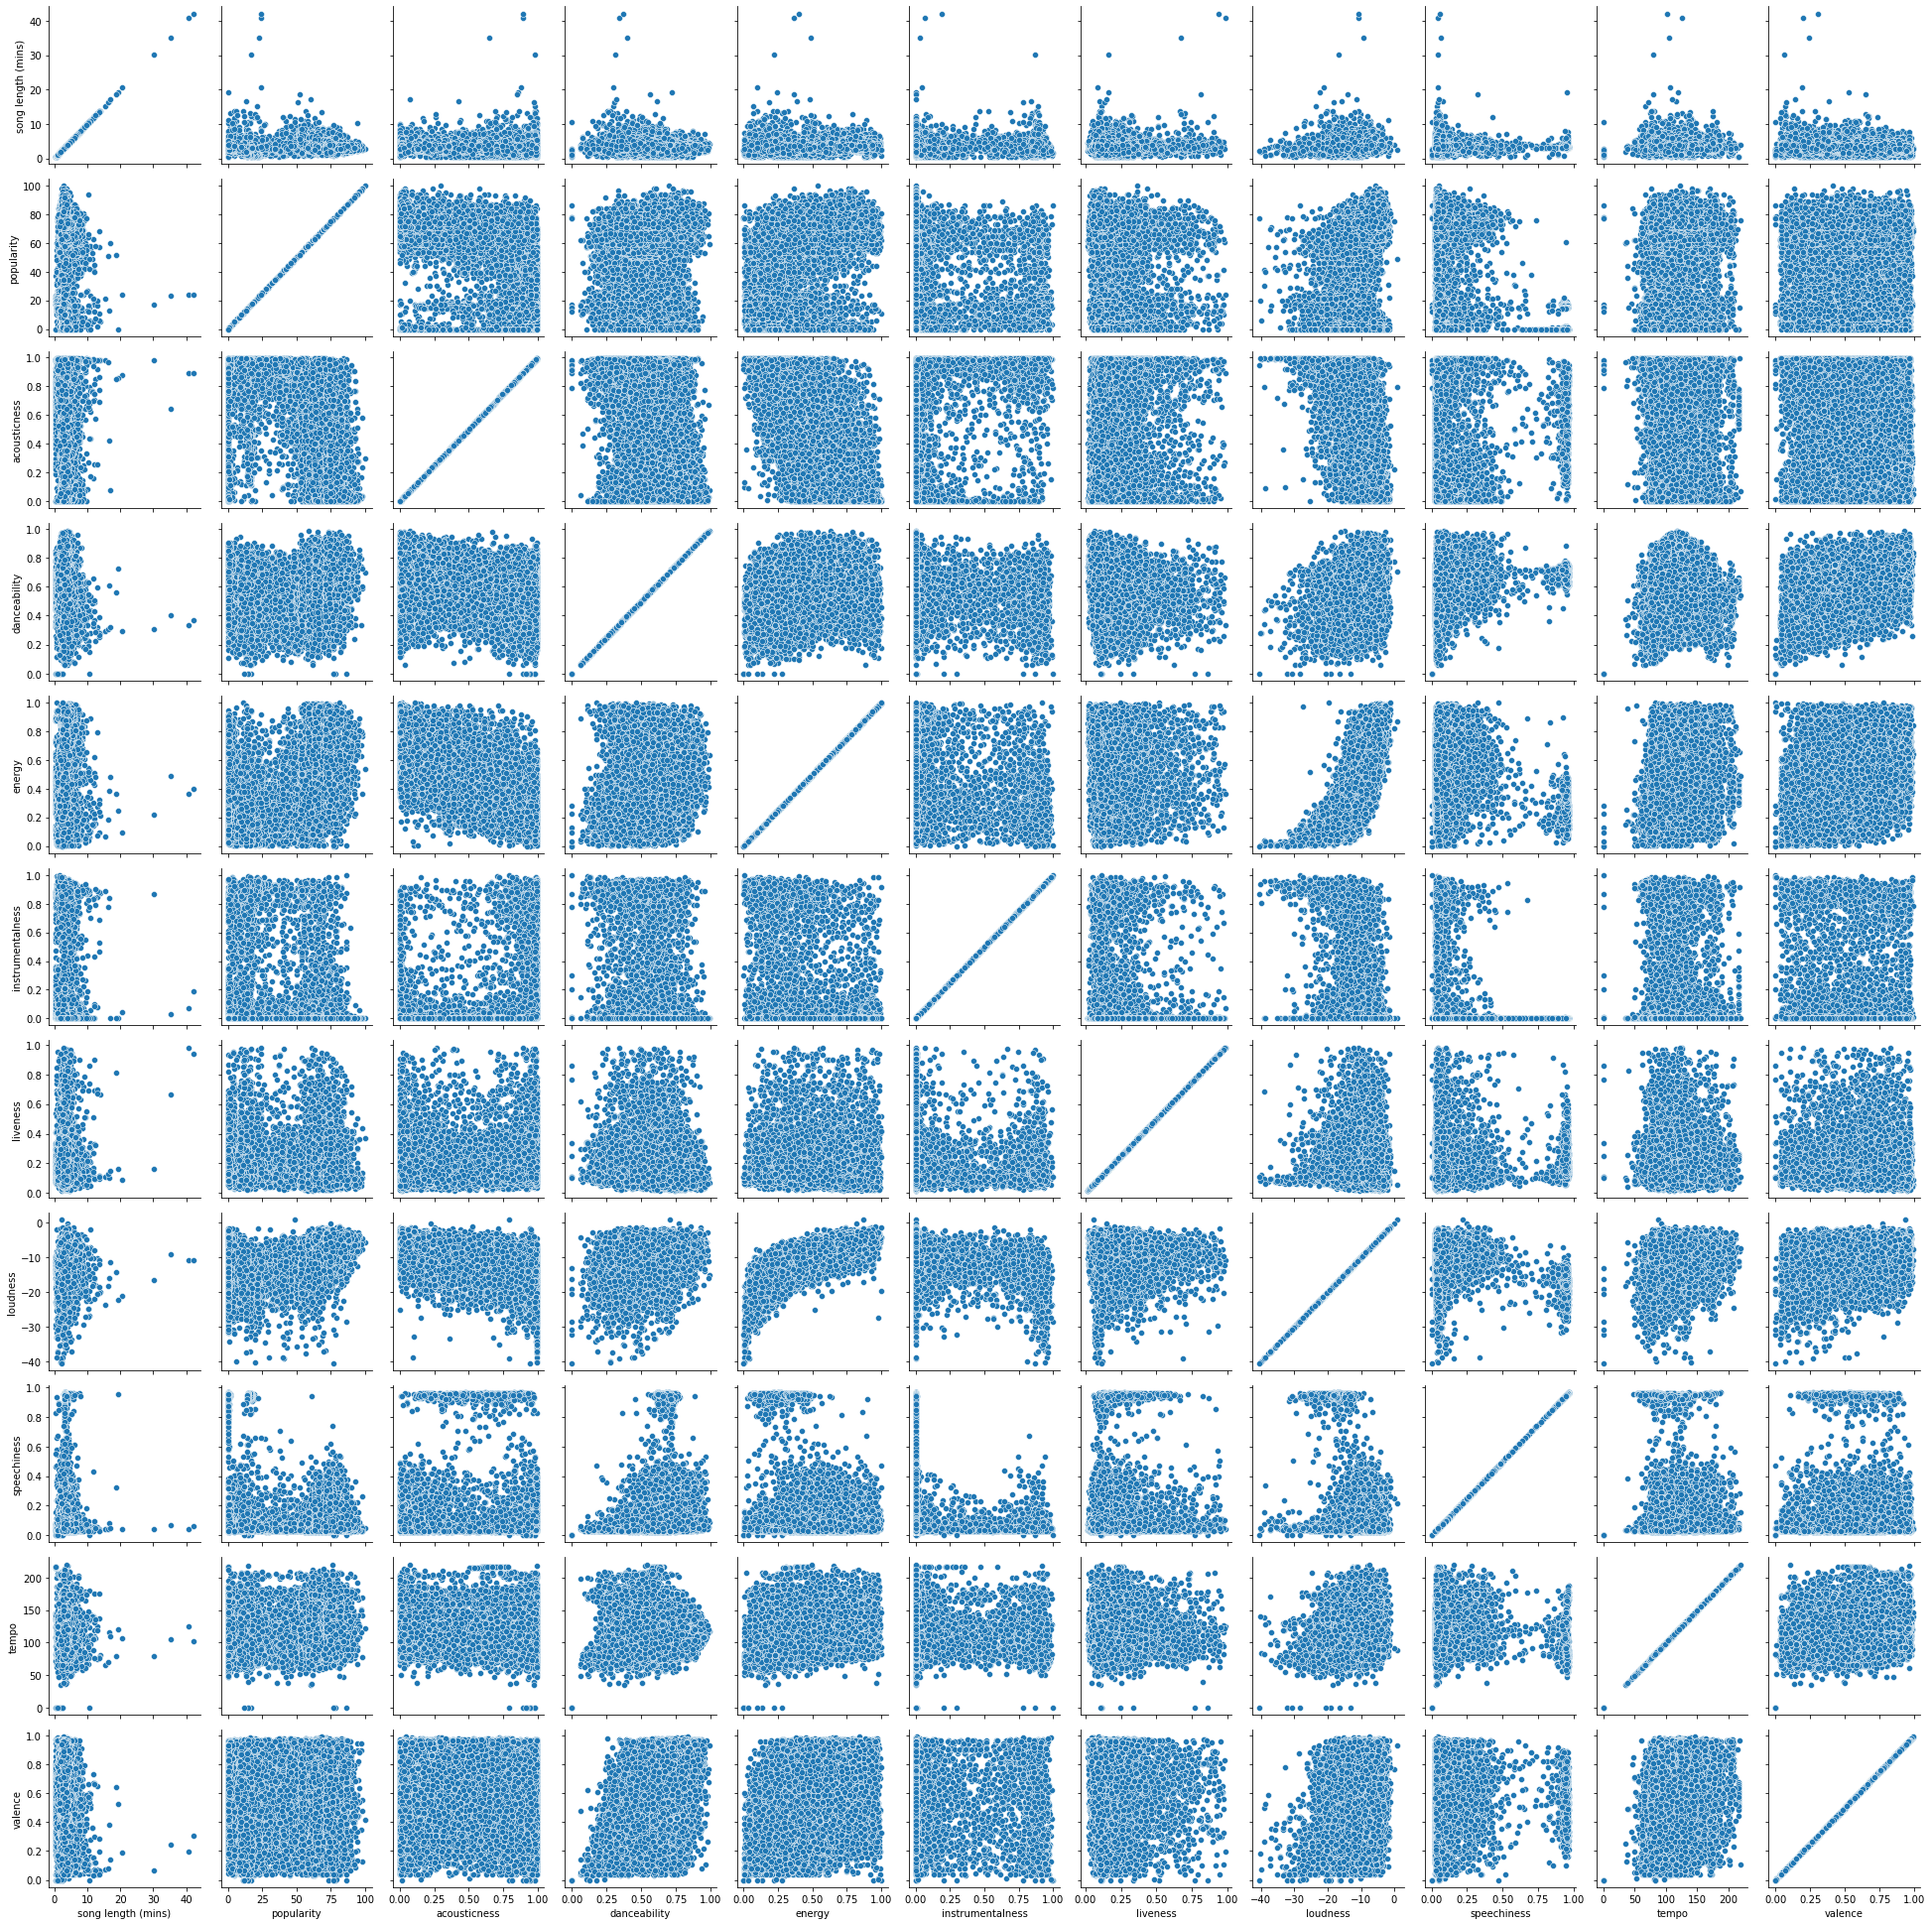

In [45]:
pairplot = sns.PairGrid(pairplot_df)


pairplot.map(sns.scatterplot)

Due to the size of the dataset, it is unsurprising that no linear relationships immediately jump out, although there are a few which show signs, such as energy and loudness, or danceability and valence. Popularity does not appear to show any strong correlations at this stage.

Ask at least three interesting questions about your dataset. Your questions may have sub-questions. The quality of your questions is assessed based on the complexity and interestingness. Trivial and basic questions will not give you full marks.

**Questions:**
- Prominent shared features of the most currently popular songs from each decade
- How popularity is affected by different audio features for each decade
- What the overall most important audio features for popularity are
- What audio features are most strongly linked for each decade
- What are the features of explicit songs? Has this changed?
- Are explicit songs becoming more popular?
- How has song length changed and does it affect popularity?
- If get album, are singles more popular than album version for duplicates?

What audio features are most important for popularity? Does decade affect this?

Firstly examine the distribution of popularity in more detail.

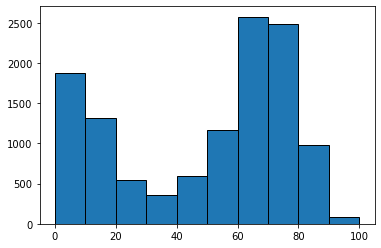

In [46]:
pop_hist = plt.hist(dataset['popularity'], edgecolor = 'black')

# title.set_text('popularity')

Regression model with all audio features or one at a time?

**QUESTION 1:** On average, does a song being explicit increase or decrease its popularity?

In [47]:
# Split data into explicit and non-explicit

explicit = dataset[dataset['explicit'] == True]

non_explicit = dataset[dataset['explicit'] == False]

#explicit

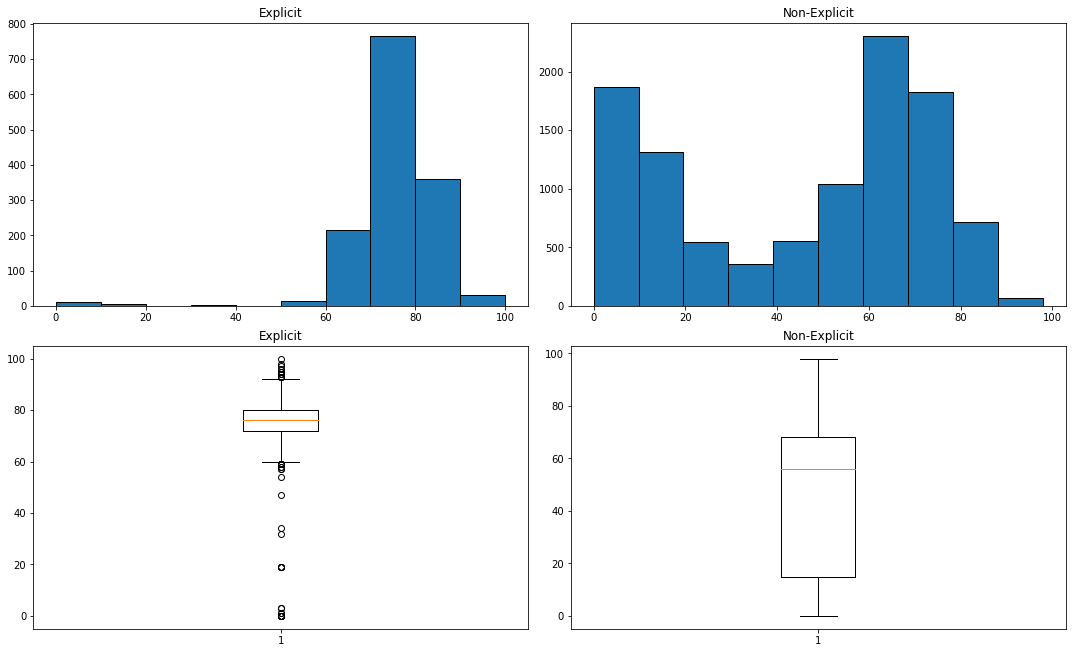

In [48]:
# Plot histograms and boxplots of each against popularity

fig, ax = plt.subplots(2, 2, figsize = (15,10))
ax[0,0].hist(explicit['popularity'], edgecolor = 'black'), ax[0,0].title.set_text('Explicit')
ax[0,1].hist(non_explicit['popularity'], edgecolor = 'black'), ax[0,1].title.set_text('Non-Explicit')
ax[1,0].boxplot(explicit['popularity']), ax[1,0].title.set_text('Explicit')
ax[1,1].boxplot(non_explicit['popularity']), ax[1,1].title.set_text('Non-Explicit')


fig.tight_layout()

#plt.suptitle("Histograms showing distribution of popularity of explicit and non-explicit songs", size = 16)

fig.subplots_adjust(top=0.88)

#plt.show()

These plots appear to show that explicit songs are often more popular, albeit on a smaller sample. However it is likely that an increasing proportion of songs are explicit nowadays, and the popularity metric is based on recent listening. We first look to confirm whether more songs are explicit in recent times.

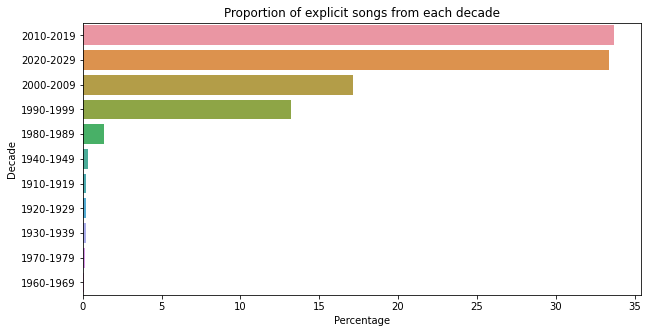

In [67]:
# explicit_decade_counts = explicit['decade'].value_counts()

# plt.figure(figsize=(12,6))
# plt.title("Does the song feature explicit lyrics?")
# plt.pie(explicit_decade_counts, labels=explicit_decade_counts.index, autopct='%1.1f%%', startangle=180);

explicit_decade_counts_pct = (explicit['decade'].value_counts()/explicit['decade'].count())*100
#plt.pie(key_counts, labels=key_counts.index, autopct='%1.1f%%', startangle=180);

# sns.countplot(y=dataset['key'])
# #plt.figure(figsize=(12,6))
# plt.title("What key is the song in?")
# #plt.xticks(rotation=75);
# #plt.title(schema['EdLevel'])
# plt.ylabel("key");


plt.figure(figsize=(10,5))
sns.barplot(x=explicit_decade_counts_pct, y=explicit_decade_counts_pct.index)
plt.title("Proportion of explicit songs from each decade")
plt.ylabel("Decade")
plt.xlabel('Percentage');

Can clearly see that an increasing proportion of songs from recent dates are explicit, with all decades before 1990 providing a combined total of less than 5% of the explicit songs.

In [50]:
# non_explicit_decade_counts_pct = (non_explicit['decade'].value_counts()/non_explicit['decade'].count())*100
# #plt.pie(key_counts, labels=key_counts.index, autopct='%1.1f%%', startangle=180);

# # sns.countplot(y=dataset['key'])
# # #plt.figure(figsize=(12,6))
# # plt.title("What key is the song in?")
# # #plt.xticks(rotation=75);
# # #plt.title(schema['EdLevel'])
# # plt.ylabel("key");


# plt.figure(figsize=(12,6))
# sns.barplot(x=non_explicit_decade_counts_pct, y=non_explicit_decade_counts_pct.index)
# plt.title("Proportion of non-explicit songs from each decade")
# plt.ylabel("Decade")
# plt.xlabel('Percentage');

Subsequently to answer the question of its effect on popularity, we further reduce the data to compare the popularity of explicit vs non-explicit songs in more recent times choosing 1990-1999 as the cut off as this is when the proportion of songs that are explicit increased greatly.

In [51]:
explicit_decades = ['1990-1999',
                    '2000-2009',
                    '2010-2019',
                    '2020-2029']

#explicit_recent = [row for row in explicit if row['decade'] in explicit_decades]

explicit_recent = explicit[explicit['decade'].isin(explicit_decades)]

non_explicit_recent = non_explicit[non_explicit['decade'].isin(explicit_decades)]

#explicit_recent

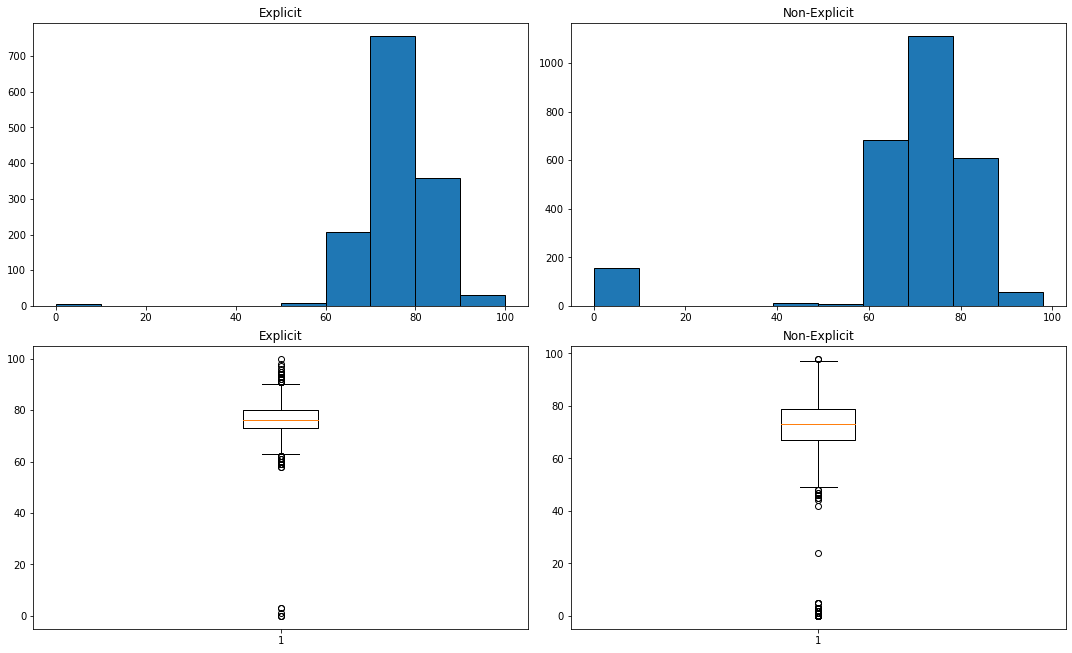

In [52]:
# Plot histograms and boxplots of each against popularity

fig, ax = plt.subplots(2, 2, figsize = (15,10))
ax[0,0].hist(explicit_recent['popularity'], edgecolor = 'black'), ax[0,0].title.set_text('Explicit')
ax[0,1].hist(non_explicit_recent['popularity'], edgecolor = 'black'), ax[0,1].title.set_text('Non-Explicit')
ax[1,0].boxplot(explicit_recent['popularity']), ax[1,0].title.set_text('Explicit')
ax[1,1].boxplot(non_explicit_recent['popularity']), ax[1,1].title.set_text('Non-Explicit')


fig.tight_layout()

#plt.suptitle("Histograms showing distribution of popularity of explicit and non-explicit songs", size = 16)

fig.subplots_adjust(top=0.88)

#plt.show()

Examining the histograms and boxplots again, subsetted on the four most recent decades shows much more similar distributions of popularity, although it appears that explicit songs are still score slightly higher on popularity on average.

**Question 2** What is the effect of each feature on popularity?

audio feature, or combination of features, can best predict popularity?

Whilst the earlier pair plot did not seem to suggest any linear relationships with popularity, it makes sense to look at it again with bigger plots.

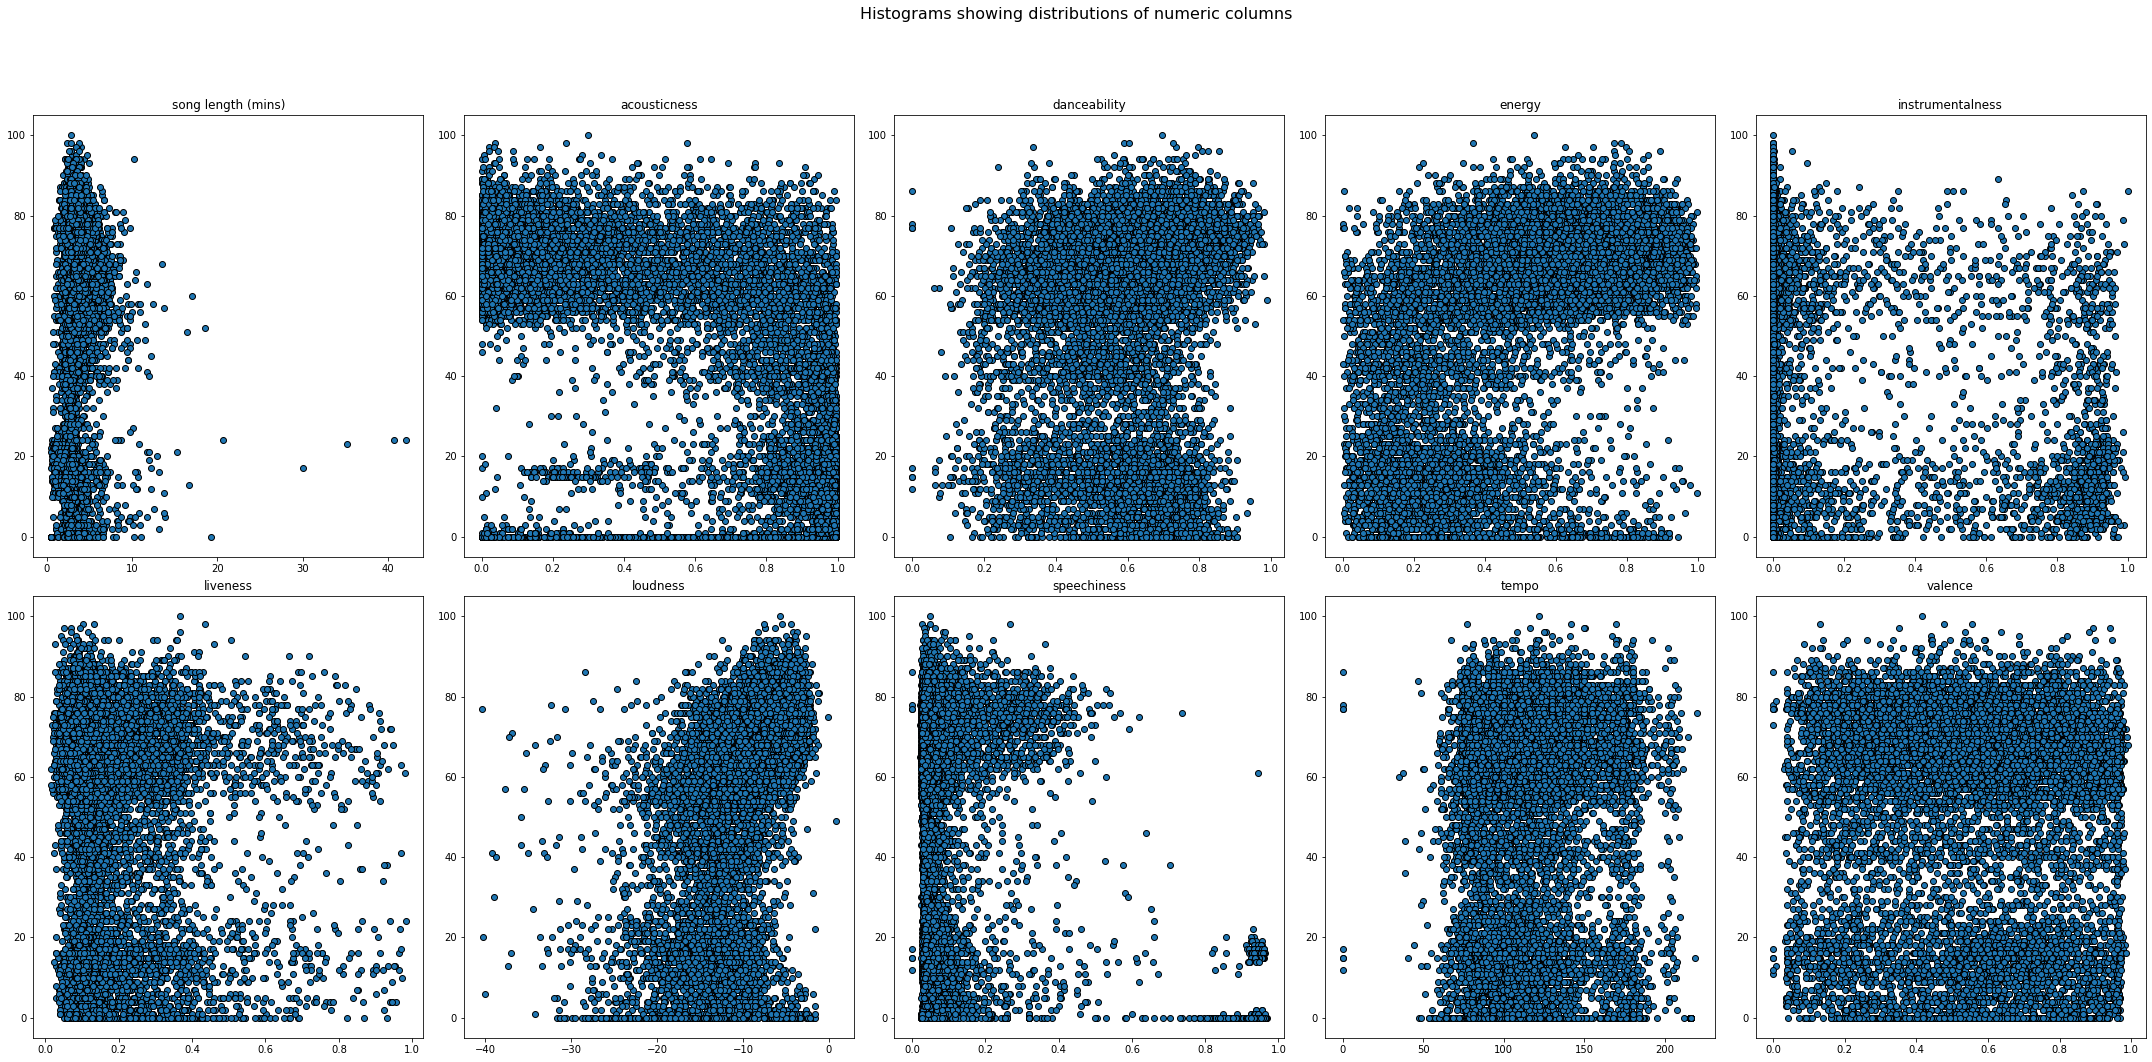

In [53]:
fig, ax = plt.subplots(2, 5, figsize = (30,15))
ax[0, 0].scatter(dataset['song length (mins)'], dataset['popularity'], edgecolor = 'black'), ax[0, 0].title.set_text('song length (mins)')
ax[0, 1].scatter(dataset['acousticness'], dataset['popularity'], edgecolor = 'black'), ax[0, 1].title.set_text('acousticness')
ax[0, 2].scatter(dataset['danceability'], dataset['popularity'], edgecolor = 'black'), ax[0, 2].title.set_text('danceability')
ax[0, 3].scatter(dataset['energy'], dataset['popularity'], edgecolor = 'black'), ax[0, 3].title.set_text('energy')
ax[0, 4].scatter(dataset['instrumentalness'], dataset['popularity'], edgecolor = 'black'), ax[0, 4].title.set_text('instrumentalness')
ax[1, 0].scatter(dataset['liveness'], dataset['popularity'], edgecolor = 'black'), ax[1, 0].title.set_text('liveness')
ax[1, 1].scatter(dataset['loudness'], dataset['popularity'], edgecolor = 'black'), ax[1, 1].title.set_text('loudness')
ax[1, 2].scatter(dataset['speechiness'], dataset['popularity'], edgecolor = 'black'), ax[1, 2].title.set_text('speechiness')
ax[1, 3].scatter(dataset['tempo'], dataset['popularity'], edgecolor = 'black'), ax[1, 3].title.set_text('tempo')
ax[1, 4].scatter(dataset['valence'], dataset['popularity'], edgecolor = 'black'), ax[1, 4].title.set_text('valence')

fig.tight_layout()

plt.suptitle("Histograms showing distributions of numeric columns", size = 16)

fig.subplots_adjust(top=0.88)



In [54]:
#prices.plot(0, 12, kind='scatter', xlabel='CRIM', ylabel='price')
#plt.scatter(dataset['song length (mins)'], dataset['popularity'])

Now some small potential correlations can be seen, in particular a positive correlation with energy and a negative correlation with acousticness. Logically, it appears that energy and acousticness may themselves be inversely correlated, which makes sense.

Whilst we have compared the correlations of the numeric variables, it is important to now also do so for the categorical variables.

/Users/freddielloyd/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


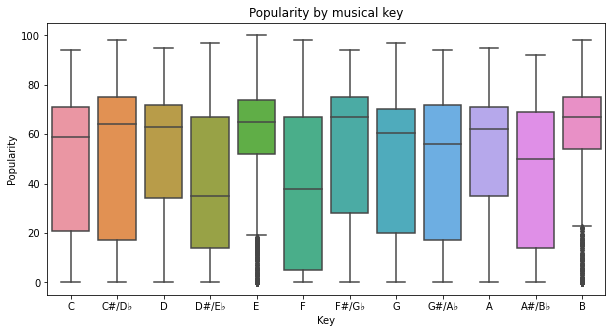

In [80]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data = dataset, x = 'key',y = 'popularity')
plt.title("Popularity by musical key")
plt.ylabel("Popularity")
plt.xlabel('Key')
ax.set_xticklabels(key_names.values());

Keys 4, 6 and 11 show the most promise, should be investigated further.

/Users/freddielloyd/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


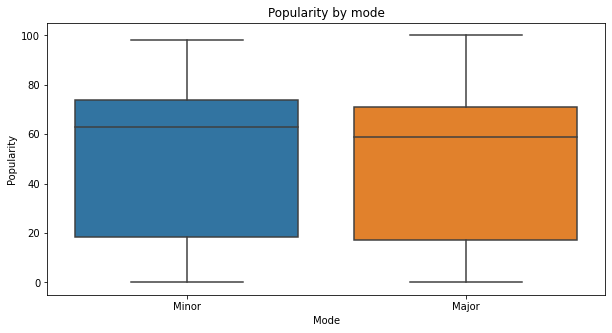

In [84]:
modes = ['Minor', 'Major']

plt.figure(figsize=(10,5))
ax = sns.boxplot(data = dataset, x = 'mode', y = 'popularity')
plt.title("Popularity by mode")
plt.ylabel("Popularity")
plt.xlabel('Mode')
ax.set_xticklabels(modes);

No apparent differences.

/Users/freddielloyd/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


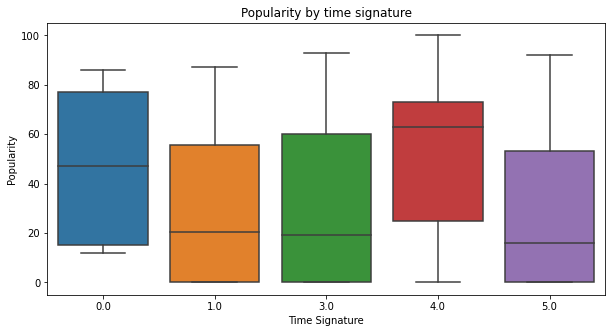

In [82]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data = dataset, x = "time signature", y = "popularity")
plt.title("Popularity by time signature")
plt.ylabel("Popularity")
plt.xlabel('Time Signature');
#ax.set_xticklabels(modes);

Time signature of 4 is the most common, also appears to be the most popular, needs further investigation to see if there is on purpose.

Preliminary exploratory data analysis leads us to further examine the influences on popularity of acoustiness, energy, keys 4,6, and 11, and time signature 4.

**Regression model**

In [58]:
# Select data of interest
x_features = [
    'acousticness',
    'energy',
    'key',
    'liveness'
]
x_df = dataset.dropna()[x_features]
y = dataset.dropna()['popularity']

In [59]:
# Regress x variables on target var
model = LinearRegression()
model.fit(x_df, y)

LinearRegression()

In [60]:
for 

SyntaxError: invalid syntax (<ipython-input-60-eaf083cb72bb>, line 1)

In [ ]:
simlinreg = LinearRegression()
x = prices_var0_training[['energy']].values.reshape(3000, 1)
y = prices_var0_training[['popularity']].values.reshape(3000,1)

In [ ]:
# fir the model
simlinreg.fit(x, y)

# evaluate model
X_test = prices_var0_testing[['energy']].values.reshape(2999, 1)
y_test = prices_var0_testing[['popularity']].values.reshape(2999, 1)


predictions = simlinreg.predict(X_test)



In [ ]:
plt.scatter(prices_var0_testing[['energy']], prices_var0_testing[['popularity']])
plt.plot(prices_var0_testing[['energy']], predictions, color='blue')

In [ ]:
simlinreg.score(X_test, y_test)

In [ ]:
x = dataset['energy'].values

y = dataset['popularity'].values

model = LinearRegression(fit_intercept=True)

#model.fit(x.reshape(6000,1), y.reshape(6000, 1))
#model.fit(x, y)




In [ ]:
#dataset.info()

In [ ]:
x = housing.frame.MedInc.values
y = housing.frame.MedHouseVal.values
model = LinearRegression(fit_intercept=True) 
model.fit(x.reshape(20640,1), y.reshape(20640, 1))
xfit = np.linspace(0, 15, 1000)
yfit = model.predict(xfit.reshape(1000, 1))
plt.scatter(x, y)
plt.plot(xfit, yfit,color="red");